In [1]:
# importacao de bibliotecas necessarias

# bibliotecas de redes neurais
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import sklearn
from sklearn.model_selection import StratifiedKFold


# bibliotecas de manipulacao de variaveis de ambiente e acesso a diretorios
import os, warnings
import glob

# bibliotecas de manipulacao e visualizacao de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preparação dos Dados

Retomamos a mesma preparação dos dados abordada na [primeira entrega](https://github.com/GFerrazzo/INE5644/blob/main/Primeira%20Entrega%20-%20Trabalho%20Final.ipynb). Dessa vez, retiramos os blocos de código com propósito de visualização da preparação.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/GFerrazzo/INE5644/main/KaggleV2-May-2016.csv', sep = ',')

# df = pd.read_csv('KaggleV2-May-2016.csv', sep = ',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [5]:
df['Gender'] = df['Gender'].map({'M' : 1, 'F' : 0})
df['No-show'] = df['No-show'].map({'Yes' : 1, 'No' : 0})

# esse bloco foi alterado para nao utilizarmos mais o dtype boolean. o Keras teve algum problema em trabalhar com esse dtype.

In [6]:
df['ScheduleToAppointment'] = (df['AppointmentDay'] - df['ScheduledDay']).astype('timedelta64[D]') + 1

In [7]:
df['ScheduleWeekDay'] = df['ScheduledDay'].dt.weekday

In [8]:
df.drop(columns=['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], inplace=True)

In [9]:
df.drop(df[df['Age'] < 0].index, inplace=True)

In [10]:
df.drop(df[df['ScheduleToAppointment'] < 0].index, inplace=True)

In [11]:
df[df['No-show'] == True].shape[0]/df.shape[0]

0.2018982817745044

In [12]:
df.drop(columns=['Neighbourhood'], inplace=True)

In [13]:
# df['Age'] = pd.cut(df['Age'], bins=29, precision=0)

In [14]:
# df['Handcap'] = df['Handcap'].map({1 : True, 2 : True, 3 : True, 4 : True, 0 : False})

In [15]:
# df['ScheduleToAppointment'] = pd.cut(df['ScheduleToAppointment'], bins=30, precision=0)

In [16]:
df.sample(5)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduleToAppointment,ScheduleWeekDay
36985,1,40,0,0,0,1,0,0,1,5.0,2
53946,0,40,0,0,0,0,0,0,0,0.0,2
53982,0,51,0,1,1,0,0,0,1,7.0,1
64131,1,43,0,1,1,0,0,0,1,8.0,1
109197,1,35,0,0,0,0,0,1,0,19.0,3


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 110521 non-null  int64  
 1   Age                    110521 non-null  int64  
 2   Scholarship            110521 non-null  int64  
 3   Hipertension           110521 non-null  int64  
 4   Diabetes               110521 non-null  int64  
 5   Alcoholism             110521 non-null  int64  
 6   Handcap                110521 non-null  int64  
 7   SMS_received           110521 non-null  int64  
 8   No-show                110521 non-null  int64  
 9   ScheduleToAppointment  110521 non-null  float64
 10  ScheduleWeekDay        110521 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 10.1 MB


In [18]:
# df['Age'] = df['Age'].cat.codes
# df['ScheduleToAppointment'] = df['ScheduleToAppointment'].cat.codes

# Primeiro Modelo

In [19]:
df_model = df.copy()

In [20]:
target = df_model.pop('No-show')

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

In [22]:
train_dataset = dataset.shuffle(len(df_model)).batch(32)

Começaremos com um modelo bem simples. Composto apenas por três camadas.

In [23]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

In [24]:
model1.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [25]:
model1_performance = model1.fit(train_dataset, epochs=10)

Epoch 1/10
3454/3454 [==============================] - 20s 6ms/step - loss: 0.4987 - accuracy: 0.7928
Epoch 2/10
3454/3454 [==============================] - 19s 5ms/step - loss: 0.4499 - accuracy: 0.7981
Epoch 3/10
3454/3454 [==============================] - 18s 5ms/step - loss: 0.4481 - accuracy: 0.7981
Epoch 4/10
3454/3454 [==============================] - 18s 5ms/step - loss: 0.4473 - accuracy: 0.7981
Epoch 5/10
3454/3454 [==============================] - 19s 5ms/step - loss: 0.4467 - accuracy: 0.7981
Epoch 6/10
3454/3454 [==============================] - 18s 5ms/step - loss: 0.4466 - accuracy: 0.7981
Epoch 7/10
3454/3454 [==============================] - 19s 5ms/step - loss: 0.4464 - accuracy: 0.7981
Epoch 8/10
3454/3454 [==============================] - 19s 5ms/step - loss: 0.4460 - accuracy: 0.7981
Epoch 9/10
3454/3454 [==============================] - 21s 6ms/step - loss: 0.4458 - accuracy: 0.7981
Epoch 10/10
3454/3454 [==============================] - 22s 6ms/step - l

Como podemos notar, ao utilizar o dataset como ele foi fornecido, chegamos numa acurácia de 79.81%. 

Coincidentemente (veremos que não é coincidência), esse é o valor do balanço das nossas classes, como podemos ver:

In [26]:
df[df['No-show'] == True].shape[0]/df.shape[0]

0.2018982817745044

In [27]:
df[df['No-show'] == False].shape[0]/df.shape[0]

0.7981017182254956

Ou seja, podemos imaginar que nosso modelo está prevendo "Presença" para todas predições, mas só acerta 79.81% das vezes.
Podemos conferir isso com uma matriz de confusão.

In [28]:
y_pred_model1 = model1.predict(df_model)

In [29]:
matriz_confusao1 = tf.math.confusion_matrix(labels=target, predictions=y_pred_model1.ravel()>0.5)
TP = matriz_confusao1.numpy()[0][0]
FP = matriz_confusao1.numpy()[0][1]
TN = matriz_confusao1.numpy()[1][0]
FN = matriz_confusao1.numpy()[1][1]
acuracia = (TP+TN)/(TP+TN+FP+FN)
f1_scr = (2*TP)/(2*TP + FP + FN)
precisao = (TP)/(TP + FP)
recall = (TP)/(TP+FN)
print(matriz_confusao1, "\n")
print("acuracia: \t", acuracia)
print("f1_scr: \t", f1_scr)
print("precisao: \t", precisao)
print("recall: \t", recall)

tf.Tensor(
[[88207     0]
 [22314     0]], shape=(2, 2), dtype=int32) 

acuracia: 	 1.0
f1_scr: 	 1.0
precisao: 	 1.0
recall: 	 1.0


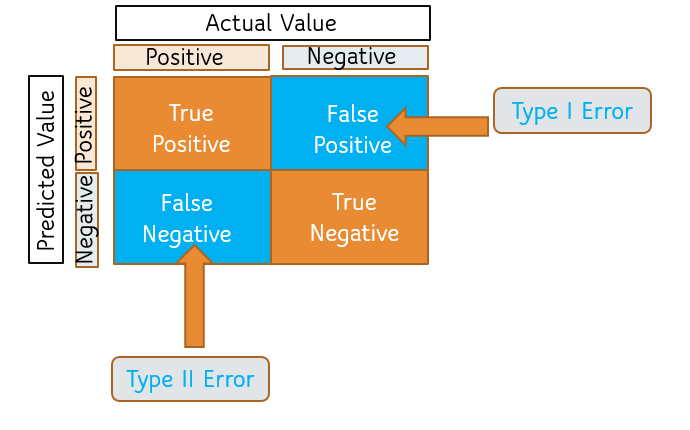

Comparando com a imagem acima (fonte), podemos notar que temos:
    88207 casos de positivos verdadeiros.
    22314 casos de falsos negativos.
    
Que nos dá a acurácia de 79.81%.

Indo além, podemos verificar pelo próprio resultado da predição, que retorna 110521 predições de "Falso":

In [30]:
y_pred_model1.ravel()>0.5

array([False, False, False, ..., False, False, False])

In [31]:
np.unique(y_pred_model1.ravel()>0.5, return_counts=True)

(array([False]), array([110521], dtype=int64))

# Segundo Modelo

O que notamos que aconteceu no primeiro modelo é o chamado "paradoxo da acurácia", onde descobrimos que a acurácia não é um método "certeiro" de medir a previsibilidade do nosso modelo. Devemos alterar dois itens no nosso primeiro modelo:
- Consertar o desbalanço das classes
- Alterar a métrica de cálculo da previsibilidade do modelo

Para o primeiro item acima, temos várias opções: undersampling, oversampling, etc. Neste segundo modelo, vamos alterar as métricas para ver o impacto que a métrica errada tinha sobre o modelo, assim como realizar um undersampling da classe majoritária e um oversampling da classe minoritária.

Temos inúmeras opções de métricas diferentes, citamos algumas, com suas nomenclaturas em inglês (para evitar traduções errôneas):
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)
- F1 Score = 2 * Recall * Precision / (Recall + Precision)
- Area Under ROC Curve
- G-Measure = sqrt(Precision * Recall)
- Jaccard Index = TP/(TP+FP+FN)


onde 

TP = True Positive

FP = False Positive

FN = False Negative

In [32]:
count_class_0, count_class_1 = df['No-show'].value_counts()
print(count_class_0, count_class_1)

88207 22314


In [33]:
df_class_0 = df[df['No-show'] == 0]
df_class_1 = df[df['No-show'] == 1]

Undersampling

In [34]:
df_class_0_resampled = df_class_0.sample(count_class_1)
df_undersampled = pd.concat([df_class_1, df_class_0_resampled])
df_undersampled['No-show'].value_counts()

1    22314
0    22314
Name: No-show, dtype: int64

Oversampling

In [35]:
df_class_1_resampled = df_class_1.sample(count_class_0, replace=True)
df_oversampled = pd.concat([df_class_0, df_class_1_resampled])
df_oversampled['No-show'].value_counts()

0    88207
1    88207
Name: No-show, dtype: int64

In [36]:
df_model = df_undersampled.copy()

target = df_model.pop('No-show')

dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

train_dataset = dataset.shuffle(len(df_model)).batch(32)

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model2.compile(optimizer='sgd',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.AUC()])

model2_performance = model2.fit(train_dataset, epochs=15)

Epoch 1/15
1395/1395 [==============================] - 13s 9ms/step - loss: 0.6830 - auc: 0.6631
Epoch 2/15
1395/1395 [==============================] - 12s 8ms/step - loss: 0.6350 - auc: 0.6855
Epoch 3/15
1395/1395 [==============================] - 12s 9ms/step - loss: 0.6287 - auc: 0.6897
Epoch 4/15
1395/1395 [==============================] - 13s 9ms/step - loss: 0.6234 - auc: 0.6963
Epoch 5/15
1395/1395 [==============================] - 13s 9ms/step - loss: 0.6198 - auc: 0.6993
Epoch 6/15
1395/1395 [==============================] - 12s 9ms/step - loss: 0.6173 - auc: 0.6994
Epoch 7/15
1395/1395 [==============================] - 13s 9ms/step - loss: 0.6147 - auc: 0.7006: 0s - loss: 0.6152 - auc
Epoch 8/15
1395/1395 [==============================] - 12s 8ms/step - loss: 0.6134 - auc: 0.7029
Epoch 9/15
1395/1395 [==============================] - 12s 8ms/step - loss: 0.6119 - auc: 0.7043
Epoch 10/15
1395/1395 [==============================] - 12s 9ms/step - loss: 0.6104 - auc: 0

In [37]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', # qual metrica sera monitorada
                              factor=0.2, # fator de multiplicacao (no caso reducao) do learning rate
                              patience=2, # quantas epocas esperamos o "plateau"
                              min_lr=0.0001 # menor learning rate possivel
                                )

In [38]:
df_model = df_oversampled.copy()

target = df_model.pop('No-show')

dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

train_dataset = dataset.shuffle(len(df_model)).batch(32)

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01) ,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision()])

model2_performance = model2.fit(train_dataset, callbacks=[reduce_lr], epochs=10)

Epoch 1/10
5513/5513 [==============================] - 71s 13ms/step - loss: 0.6677 - recall: 0.5590 - auc_1: 0.6394 - precision: 0.6075
Epoch 2/10
5513/5513 [==============================] - 73s 13ms/step - loss: 0.6477 - recall: 0.6177 - auc_1: 0.6681 - precision: 0.63081s - loss: 0.6477 - recall: 
Epoch 3/10
5513/5513 [==============================] - 86s 16ms/step - loss: 0.6400 - recall: 0.6708 - auc_1: 0.6748 - precision: 0.6289
Epoch 4/10
5513/5513 [==============================] - 78s 14ms/step - loss: 0.6378 - recall: 0.6975 - auc_1: 0.6783 - precision: 0.6298
Epoch 5/10
5513/5513 [==============================] - 97s 18ms/step - loss: 0.6419 - recall: 0.7289 - auc_1: 0.6700 - precision: 0.6260
Epoch 6/10
5513/5513 [==============================] - 103s 18ms/step - loss: 0.6393 - recall: 0.7526 - auc_1: 0.6726 - precision: 0.6239
Epoch 7/10
5513/5513 [==============================] - 125s 22ms/step - loss: 0.6343 - recall: 0.7870 - auc_1: 0.6787 - precision: 0.6200
Epoc

In [39]:
y_pred_model2 = model2.predict(df_model)
matriz_confusao2 = tf.math.confusion_matrix(labels=target, predictions=y_pred_model2.ravel()>0.5)
TP = matriz_confusao2.numpy()[0][0]
FP = matriz_confusao2.numpy()[0][1]
TN = matriz_confusao2.numpy()[1][0]
FN = matriz_confusao2.numpy()[1][1]
acuracia = (TP+TN)/(TP+TN+FP+FN)
f1_scr = (2*TP)/(2*TP + FP + FN)
precisao = (TP)/(TP + FP)
recall = (TP)/(TP+FN)
print(matriz_confusao2, "\n")
print("acuracia: \t", acuracia)
print("f1_scr: \t", f1_scr)
print("precisao: \t", precisao)
print("recall: \t", recall)

tf.Tensor(
[[40716 47491]
 [11295 76912]], shape=(2, 2), dtype=int32) 

acuracia: 	 0.2948235400818529
f1_scr: 	 0.3956178492481842
precisao: 	 0.4615960184565851
recall: 	 0.34614207501615263


Pela matriz de confusão podemos perceber uma melhora na predição do modelo, porém ainda não temos resultados totalmente satisfatórios.

# Terceiro Modelo

Para esse modelo, vamos deixar para trás a utilização de redes neurais e utilizar um mobelo de gradient boosting.

In [40]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay

In [41]:
target = 'No-show'
feat_cols = [col for col in df.columns if col != target]

In [42]:
train_split = 70000

x = df.iloc[:train_split][feat_cols]
y = df.iloc[:train_split][target]

model_params = {
    "objective": 'binary',
    "max_depth": -1,
    "num_leaves": 9,
    "learning_rate": 0.1,
    "n_estimators": 100,
    "boosting_type": "rf",
    "min_data_in_leaf": 100,
    "bagging_freq": 4,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7,
    "colsample_bytree": 0.5,
#     "is_unbalance": True,
    "scale_pos_weight": 1.78,
    "metric": "auc"
}

model3 = lgb.LGBMRegressor(**model_params).fit(x, y)

test_df = (
    df
    .iloc[train_split:]
    .assign(pred = lambda df: pd.DataFrame(model3.predict(df[feat_cols])).values)
)

print(roc_auc_score(test_df[target], test_df['pred']))

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.7192157948702199


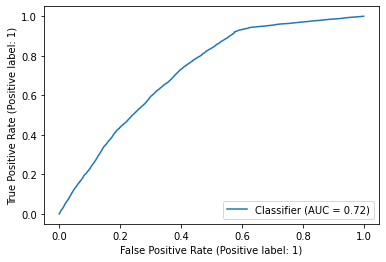

In [43]:
RocCurveDisplay.from_predictions(test_df[target], test_df['pred'])

<AxesSubplot:>

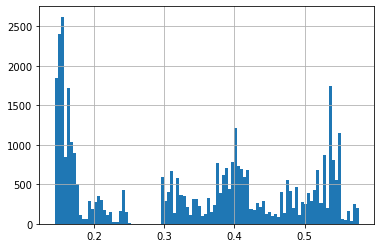

In [44]:
test_df['pred'].hist(bins=100) 

In [45]:
y_pred_model3 = model3.predict(df[feat_cols])
matriz_confusao = tf.math.confusion_matrix(labels=df[target], predictions=y_pred_model3.ravel()>0.53)
TP = matriz_confusao.numpy()[0][0]
FP = matriz_confusao.numpy()[0][1]
TN = matriz_confusao.numpy()[1][0]
FN = matriz_confusao.numpy()[1][1]
acuracia = (TP+TN)/(TP+TN+FP+FN)
f1_scr = (2*TP)/(2*TP + FP + FN)
precisao = (TP)/(TP + FP)
recall = (TP)/(TP+FN)
print(matriz_confusao, "\n")
print("acuracia: \t", acuracia)
print("f1_scr: \t", f1_scr)
print("precisao: \t", precisao)
print("recall: \t", recall)


tf.Tensor(
[[79618  8589]
 [17304  5010]], shape=(2, 2), dtype=int32) 

acuracia: 	 0.8769555107174202
f1_scr: 	 0.921318020076952
precisao: 	 0.902626775652726
recall: 	 0.9407997353121899


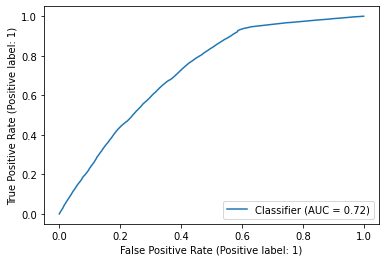

In [46]:
RocCurveDisplay.from_predictions(df[target], y_pred_model3)

Finalmente, chegamos a um modelo, de certo modo, satisfatório. Ainda temos 17304+8589 = 25893 casos de erro, dentre 110521 instâncias totais. Um alto erro, porém, a maioria (17304) dessas instâncias erradas é um Erro Tipo 1, ou seja, Falso Negativo. 

Esse tipo de erro, para nosso negócio, nao é tão problemático. Trata-se dos casos onde o modelo preveu que o paciente não faltaria à consulta, mas acabou faltando (lembrando que nossa classe 1 significa ausência à consulta). Esses casos de erro são pouco prejudiciais para nossa análise. Pois a ideia do modelo é que a clínica/consultório médico que o utilize, possa tomar ações baseadas na predição que o paciente irá se ausentar, seja realizando um "overbooking" para o horário da consulta deste paciente, ou liberando o médico de seu compromisso.

Já para o caso do Erro Tipo 2 (8589 ocorrências), o modelo prevê que o paciente irá se ausentar, mas ele acaba comparecendo a clínica, portanto, esse erro é extremamente indesejado para nosso negócio.

Podemos concluir, com base nas métricas F1 Score, Precisão e Recall, além claro da Acurácia, que nosso modelo tem uma boa predição, ainda assim. Claramente longe do ideal, como podemos perceber pela área abaixo da curva de característica de operação do receptor (abreviaremos para AUC), que em nosso modelo final estabilizou em 0.72, uma medida que coloca nosso modelo levemente abaixo de um modelo moderado, que seria entre 0.75 e 0.85 (D' Agostino, Rodgers, & Mauck, 2018).


# Problemas

Concluímos que nosso dataset não dispõe de atributos suficientes e significativos para construir um modelo preditivo com métricas satisfatórias. Acreditamos que caso fosse empenhado muito mais horas de trabalho sobre o modelo, seria possível elevar suas métricas para, no máximo, encaixar-se na definição de um modelo moderado, com AUC próximo a 0.75.

A ausência de outros modelos construídos sobre esse dataset com predições mais precisas que o nosso reforça nosso pensamento, poucos modelos foram capazes de passar a acurácia de 70%. Poderíamos ter utilizado `Neighbourhood` como um atributo a mais, entretanto, como relatado na Análise Exploratória dos Dados, a amostragem de alguns bairros era muito baixa, com alguns bairros tendo menos de 10 amostras cada, portanto, mantemos nosso entendimento de que o bairro não é significante para o modelo.

Outro dado removido que repensamos seu uso foi o identificador único do paciente. Partimos, agora, da hipótese que alguém que já faltou tenderá a faltar de novo outra consulta, verificaremos:

In [47]:
df = pd.read_csv('https://raw.githubusercontent.com/GFerrazzo/INE5644/main/KaggleV2-May-2016.csv',
                 sep = ',', 
                 usecols=['PatientId', 'No-show'], 
                 dtype={'PatientId':'str'})

<AxesSubplot:xlabel='PatientId'>

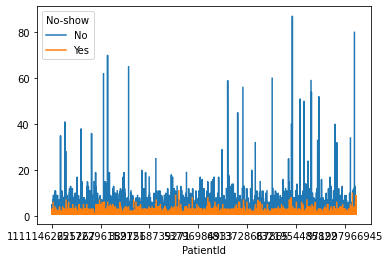

In [48]:
df = df.groupby(['PatientId', 'No-show']).size().to_frame(name = 'size').reset_index()
df.pivot(index='PatientId', columns='No-show', values='size').plot()

Podemos verificar visualmente acima que a taxa de ausência para cada paciente segue um claro padrão, ou seja, não conseguiríamos extrair informações adicionais deste atributo.

# Conclusão

Por fim, concluímos que o modelo pode trazer uma predição razoável da ausência à consultas agendadas em consultórios médicos, mas percebemos a ausência de atributos mais significativos no dataset, por isso o resultado não-ideal.

# Referências

- Addressing Inadequacies of the Observation Survey of Early Literacy Achievement;
    - D'Agostino, Jerome V.; Rodgers, Emily; Mauck, Susan;
    - Jan-Mar 2018
    - encontrado em https://eric.ed.gov/?id=EJ1165286